# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import pandas as pd

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
31886,50,Local-gov,117496,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,24,United-States,<=50K
5266,23,Self-emp-not-inc,191283,HS-grad,9,Never-married,Transport-moving,Own-child,White,Male,0,0,40,United-States,<=50K
5357,36,Private,228190,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,20,United-States,<=50K
18350,44,Local-gov,124692,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,35,United-States,>50K
31082,47,Local-gov,140644,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
25871,64,Self-emp-not-inc,253296,HS-grad,9,Widowed,Other-service,Other-relative,White,Female,0,0,40,United-States,<=50K
1485,31,Private,209448,10th,6,Married-civ-spouse,Farming-fishing,Husband,White,Male,2105,0,40,Mexico,<=50K
12062,39,Private,77005,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,40,United-States,>50K
21744,45,Federal-gov,102569,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
8344,27,Private,106758,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,45,United-States,<=50K


In [ ]:
x_train= pd.read_csv(r"C:\Users\blenc\Desktop\ADC\An II\Sem I\Machine Learning\Task 1 Proiect\X_train.csv")
x_test= pd.read_csv(r"C:\Users\blenc\Desktop\ADC\An II\Sem I\Machine Learning\Task 1 Proiect\X_test.csv")
y_train= pd.read_csv(r"C:\Users\blenc\Desktop\ADC\An II\Sem I\Machine Learning\Task 1 Proiect\y_train.csv")
y_test= pd.read_csv(r"C:\Users\blenc\Desktop\ADC\An II\Sem I\Machine Learning\Task 1 Proiect\y_test.csv")

#Incarcare seturi de date pentru antrenare si testare.

In [32]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=42
)

Training data au fost impartite in seturi de antrenare si validare.

In [ ]:

print(x_train.dtypes[x_train.dtypes == 'object'])


x_train= pd.get_dummies(x_train, drop_first=True)
x_test= pd.get_dummies(x_test, drop_first=True)


x_test= x_test.reindex(columns=x_train.columns, fill_value=0)

#creat pentru a rezolva problema "ValueError: could not convert string to float: 'adult'" din caseta urmatoare

Series([], dtype: object)


In [14]:
from sklearn.linear_model import LinearRegression

lr= LinearRegression()
lr.fit(x_train, y_train)

y_pred_lr= lr.predict(x_test)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import numpy as np

mse_lr=np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr= r2_score(y_test, y_pred_lr)
mae_lr= mean_absolute_error(y_test, y_pred_lr)

print("R2:", r2_lr)
print("MSE:", mse_lr)
print("MAE:", mae_lr)

R2: 0.29303431025319193
MSE: 3.383227787179277
MAE: 2.6389074005905426


Modelul de regresie liniara are scorul R2 de 0.29 ceea ce indica faptul ca aproximativ 29% din variatia numarului de ore lucrate pe saptamana este explicata de model.
MAE (eroarea medie absoluta) este de 2.63 ceea ce indica faptul ca in medie, predictiile modelul difera de valorile reale cu 2-3 (aproximativ).
MSE (eroarea medie patratica) este de 3.38 ore.

In [34]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(
    loss="squared_error",
    random_state=42,
    max_iter=2000,
    tol=1e-3
)

sgd.fit(X_tr, y_tr.values.ravel())
y_val_sgd = sgd.predict(X_val)
y_test_sgd = sgd.predict(x_test)

In [35]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_tr, y_tr)

y_val_dt = dt.predict(X_val)
y_test_dt = dt.predict(x_test)

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor(n_estimators=200, random_state=42,n_jobs=-1)
rf.fit(x_train, y_train.values.ravel())
y_pred_rf= rf.predict(x_test)



In [22]:
mse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest R2:", r2_rf)
print("Random Forest RMSE:", mse_rf)
print("Random Forest MAE:", mae_rf)

Random Forest R2: 0.23127566015813128
Random Forest RMSE: 3.5279090999453517
Random Forest MAE: 2.658532097585157


Comparatie Modele

Regresia liniara a obtinut un scor R2 mai mare decat Random Forest, aratand ca relatiile liniare explica mai bine variabila tinta in acest set de date.

MAE si MSE sunt putin mai mici pentru regresia liniara, aratand predictii mai precise si stabile.

Rezultatele indica faptul ca o complexitate mai mare a modelului nu duce in mod sigur la o performanta mai buna si ca relatia dintre caracteristici si ore de lucru poate fi preponderent liniara.

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }

In [40]:
experiments = []

experiments.append({
    "Model": "Linear Regression (baseline)",
    **evaluate(y_test, y_pred_lr)
})

experiments.append({
    "Model": "SGDRegressor (squared_error)",
    **evaluate(y_test, y_test_sgd)
})

experiments.append({
    "Model": "Decision Tree (baseline)",
    **evaluate(y_test, y_test_dt)
})

experiments.append({
    "Model": "Random Forest",
    **evaluate(y_test, y_pred_rf)
})

results_df = pd.DataFrame(experiments).sort_values("RMSE")
results_df

,Model,MAE,MSE,RMSE,R2
0,Linear Regression (baseline),2.638907,11.446230,3.383228,0.293034
1,SGDRegressor (squared_error),2.621168,11.521225,3.394293,0.288402
3,Random Forest,2.658532,12.446143,3.527909,0.231276
2,Decision Tree (baseline),2.902486,23.265774,4.823461,-0.436989


RMSE a fost ales ca metrica principala de evaluare deoarece sanctioneaza mai sever erorile mari, si a evidentiat existenta unor valori extreme pentru variabila tinta de ore lucrate pe saptamana. In cazul modelului SGDRegressor, am utilizat pierderea eorii patratice, deoarece aceasta este in legatura cu optimizarea rmse si asigura o convergenta stabila pentru sarcinile de regresie continua.

Regresia liniara este utilizata ca model de baza deoarece ofera simplitate si interpretabilitate insa presupune existenta unor relatii liniare variabile. SGDRegression optimizeaza parametrii prin caderea gradientului, fiind potrivit pentru seturi mari de date si pentru scenarii clasice de optimizare in ml. Random Forest atenueaza problema supraajustarii prin combinarea mai multor arbori.

In [27]:
import pandas as pd
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2': [r2_lr, r2_rf],
    'MSE': [mse_lr, mse_rf],
    'MAE': [mae_lr, mae_rf]
})
print(results)

               Model        R2       MSE       MAE
0  Linear Regression  0.293034  3.383228  2.638907
1      Random Forest  0.231276  3.527909  2.658532


In [38]:
importances = pd.Series(rf.feature_importances_, index=x_train.columns)
top10 = importances.sort_values(ascending=False).head(10)
top10

fnlwgt                        0.250430
full_time                     0.209226
age                           0.140674
education-num                 0.036216
income_>50K                   0.030299
capital-gain                  0.022656
capital-loss                  0.014609
workclass_Self-emp-not-inc    0.012908
sex_Male                      0.011429
relationship_Not-in-family    0.011385
dtype: float64

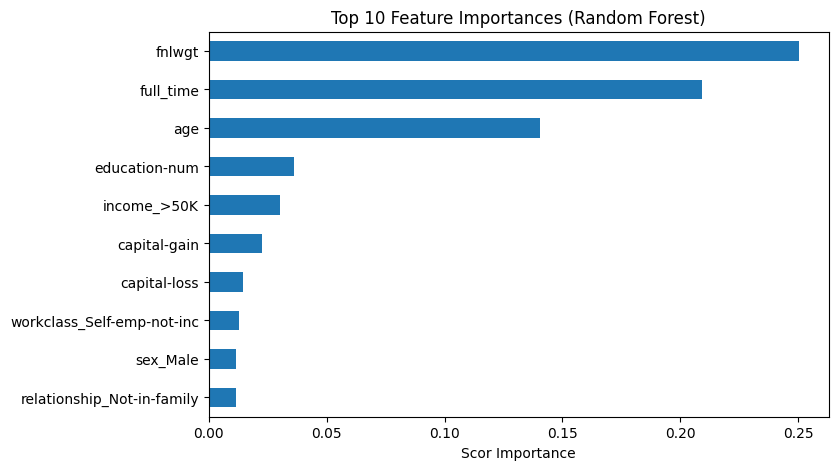

In [39]:
import matplotlib.pyplot as plt

top10.sort_values().plot(kind='barh',figsize=(8,5))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Scor Importance')
plt.show()

Analiza modelului Random Forest arata ca fnlwgt, full_time si age sunt cei mai importanti factori in predictia numarului de ore lucrate pe saptamana.Variabila full_time,
are un impact semnificativ, ceea ce confirma utilitatea sa in model. Nivelul de educatie ;i categoria de venit influenteaza rezultatele, de asemenea,
in timp ce valorile demografice au o influenta mai redusa.